# Face Evaluation with Masked Images Using Landmarks
This example shows how to estimate skin color by calculating Individual Typology Angle(ITA) 

Diversity in Faces<br>
Michele Merler, Nalini Ratha, Rogerio S. Feris, John R. Smith, arXiv (2019)<br>
https://arxiv.org/abs/1901.10436

Let's start by installing nnabla and accessing nnabla-examples repository.

In [20]:
!git clone https://github.com/sony/nnabla-examples.git
%cd nnabla-examples/responsible_ai/face_evaluation

Cloning into 'nnabla-examples'...
remote: Enumerating objects: 4897, done.
remote: Counting objects: 100% (662/662), done.
remote: Compressing objects: 100% (414/414), done.
remote: Total 4897 (delta 307), reused 500 (delta 234), pack-reused 4235
Receiving objects: 100% (4897/4897), 173.02 MiB | 35.03 MiB/s, done.
Resolving deltas: 100% (2515/2515), done.
/content/nnabla-examples/responsible_ai/face_evaluation/nnabla-examples/responsible_ai/face_evaluation/nnabla-examples/responsible_ai/face_evaluation


Let's start by importing dependencies.

In [21]:
import numpy as np
import cv2
import urllib.request
import os
from matplotlib import pyplot as plt

from face_evaluation import extract_non_black, calc_ita

# !pip install opencv-contrib-python

# Preparation
Get the image to estimate skin color<br> 
Take a look at what the image looks like

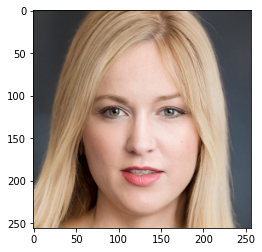

In [22]:
url_faces = 'https://github.com/sony/nnabla-examples/blob/master/GANs/stylegan2/images/sample.png?raw=true'
faces_path = 'faces.png'
if not os.path.isfile(faces_path):
    tgt = urllib.request.urlopen(url_faces).read()
    with open(faces_path, mode='wb') as f:
        f.write(tgt)
img = cv2.imread('faces.png')
img = img[:, 512:768]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

download files to detect faces and landmarks

In [23]:
# file to detect faces
url_cascade = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_alt2.xml'
cascade_path = 'haarcascade_frontalface_alt2.xml'
if not os.path.isfile(cascade_path):
    tgt = urllib.request.urlopen(url_cascade).read()
    with open(cascade_path, mode='wb') as f:
        f.write(tgt)
        
# file to detect landmarks
url_landmark = 'https://github.com/kurnianggoro/GSOC2017/raw/master/data/lbfmodel.yaml'
landmark_path = 'lbfmodel.yaml'
if not os.path.isfile(landmark_path):
    tgt = urllib.request.urlopen(url_landmark).read()
    with open(landmark_path, mode='wb') as f:
        f.write(tgt)


In [24]:
cas = cv2.CascadeClassifier(cascade_path)

obj = cv2.face.createFacemarkLBF()
obj.loadModel(landmark_path)

# Mask the image using landmarks

Now let's define a function to mask the image using landmarks

In [25]:
def make_masked_face_image( faces, index, img, img_copy,gray_img):
    mask_r = np.zeros_like(img)
    mask_c = np.zeros_like(img)
    mask_l = np.zeros_like(img)
    # dlib numbers
    r_cheek = [2, 3, 4, 5, 32]
    chin = [5, 6, 7, 8, 9, 10, 11, 57] 
    l_cheek = [11, 12, 13, 14, 35]
    # detect landmarks
    ok, landmarks = obj.fit(gray_img, faces)    
    for landmark in landmarks[0][0]:
        tup=(landmark[0], landmark[1])
        cv2.drawMarker(img_copy, tup, (255, 0, 0),markerSize=10, thickness=1)
    landmarks = np.array(landmarks)

    r_cheek_poly = np.empty([0, 2], int)
    l_cheek_poly = np.empty([0, 2], int)
    chin_poly = np.empty([0, 2], int)

    for mark in r_cheek:
        r_cheek_poly = np.append(r_cheek_poly, np.array([landmarks[index][0][mark]]), axis=0)
    for mark in l_cheek:
        l_cheek_poly = np.append(l_cheek_poly, np.array([landmarks[index][0][mark]]), axis=0)
    for mark in chin:
        chin_poly = np.append(chin_poly, np.array([landmarks[index][0][mark]]), axis=0)
    # create mask
    cv2.fillConvexPoly(mask_r, np.array(r_cheek_poly, 'int32'), color=(255, 255, 255))
    cv2.fillConvexPoly(mask_l, np.array(l_cheek_poly, 'int32'), color=(255, 255, 255))
    cv2.fillConvexPoly(mask_c, np.array(chin_poly, 'int32'), color=(255, 255, 255))
    img_filtered = cv2.blur(img, ksize=(12, 12))

    return np.where(mask_r == 255, img_filtered, mask_r), np.where(mask_c == 255, img_filtered, mask_c), np.where(mask_l == 255, img_filtered, mask_l), img_copy


Let's take a look at how the landmarks are plotted, and how the image is masked.
We will extract the right cheek, the chin, and the left cheek.

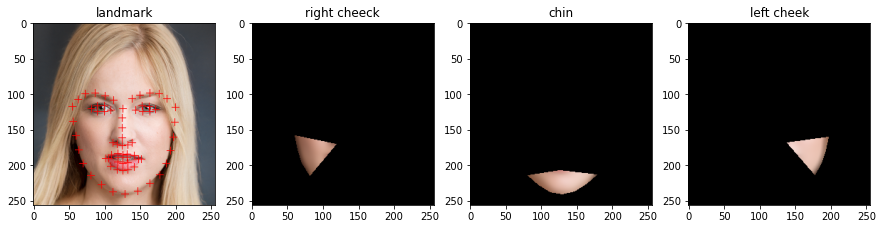

In [26]:
img_copy = img.copy()
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
faces = cas.detectMultiScale(gray_img)
img_r, img_c, img_l,landmark_image = make_masked_face_image(faces, 0, img, img_copy, gray_img)


images = {
    'landmark': landmark_image,
    'right cheeck': img_r,
    'chin': img_c,
    'left cheek': img_l
}

row = 1
col = len(images)
fig, axes = plt.subplots(row, col, figsize=(15,15))

for i, (k, v) in enumerate(images.items()):
    axes[i].imshow(v)
    axes[i].set_title(k)

# Calculate the ITA
Now we calculate the ITA.<br>
In particular, we calculate the ITA for 3 masked images(right cheeck, chin, left cheek), then take the mean.

In [29]:
img_r = extract_non_black(img_r)
img_c = extract_non_black(img_c)
img_l = extract_non_black(img_l)
ita = calc_ita([img_r, img_c, img_l])

In [30]:
print("Individual Typology Angle(ITA) : ", ita)

Individual Typology Angle(ITA) :  64.05


# ITAs for different faces
Lastly, Let's take a look at how the ITA is calculated for different faces

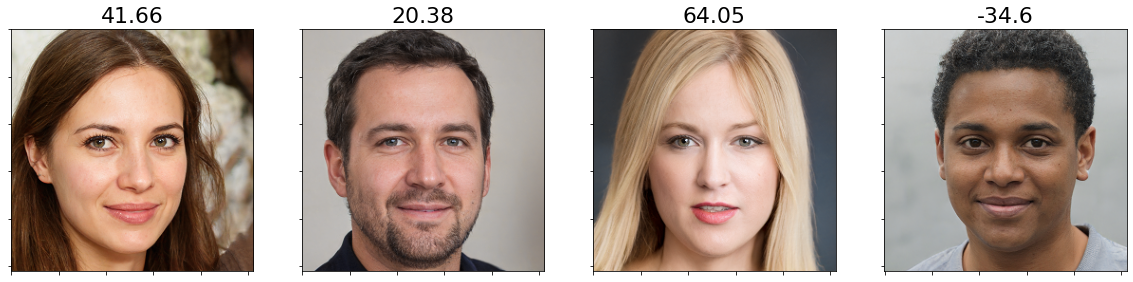

In [31]:
img = cv2.imread('faces.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_copy = img.copy()
gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
faces = cas.detectMultiScale(gray_img)
ITAs = []
for i in range(len(faces)):
    img_r, img_c, img_l,landmark_image = make_masked_face_image(faces, i, img, img_copy, gray_img)
    img_r = extract_non_black(img_r)
    img_c = extract_non_black(img_c)
    img_l = extract_non_black(img_l)
    ita = calc_ita([img_r, img_c, img_l])
    ITAs.append(ita)
images = dict()
for i,j in enumerate(range(0,1024,256)):
    face_img = img[:, j:j+256]
    images[str(ITAs[i])] = face_img 
    
row = 1
col = len(images)
fig, axes = plt.subplots(row, col, figsize=(20,20))

for i, (k, v) in enumerate(images.items()):
    axes[i].imshow(v)
    axes[i].set_title(k, fontsize=22)
    axes[i].tick_params(labelbottom=False,
               labelleft=False,
               labelright=False,
               labeltop=False)
